# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import janitor
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import PercentFormatter
px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from mlxtend.plotting import plot_decision_regions
from sklearn import __version__ as sklearn_version
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,
                              GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor,
                              VotingClassifier)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, average_precision_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, plot_precision_recall_curve,
                             precision_recall_curve, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     cross_validate, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (LabelEncoder, MaxAbsScaler, MinMaxScaler, Normalizer,
                                   StandardScaler, normalize, scale)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [5]:
import joblib
import requests
from dotenv import load_dotenv
load_dotenv()
APIKEY = os.getenv("SOME_KEY")
%reload_ext watermark
%watermark -a 'Ken Cavagnolo' -n -u -v -m -h -g -p jupyter,notebook,pandas,numpy,scipy

Author: Ken Cavagnolo

Last updated: Thu Sep 30 2021

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.25.0

jupyter : 1.0.0
notebook: 6.4.0
pandas  : 1.3.0
numpy   : 1.19.5
scipy   : 1.7.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.13.0-7614-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Hostname: goldfinch

Git hash: 3a34f6ef9528de3af72bc8af0d57f8331fdf589b



# GPU Check

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import torch
from tensorflow.python.client import device_lib

hello = tf.constant("Hello, TensorFlow!")
with tf.device("/gpu:0"):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name="a")
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name="b")
    c = tf.matmul(a, b)
print("-" * 20)
print("<<< Testing Tensorflow >>>")
print("<<< Version: ", tf.__version__)
print("<<< Eager mode: ", tf.executing_eagerly())
print("<<< Hub version: ", hub.__version__)
print(
    "<<< GPU is",
    "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE",
)
print("<<< Code check...")
tf.print(hello)
tf.print(c)
print("-" * 20)

# torch
print("-" * 20)
print("<<< Testing Torch >>>")
print(f"<<< Version: {torch.__version__}")
print(
    "<<< GPU is",
    "available"
    if any("GPU" in d.name for d in device_lib.list_local_devices())
    else "NOT AVAILABLE",
)
print("<<< CUDA is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")
print("<<< Code check...")
x = torch.rand(5, 3)
print(x)
print("-" * 20)


2021-09-30 16:59:56.020611: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-30 16:59:56.680784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2397 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:07:00.0, compute capability: 7.5


--------------------
<<< Testing Tensorflow >>>
<<< Version:  2.6.0
<<< Eager mode:  True
<<< Hub version:  0.12.0
<<< GPU is available
<<< Code check...
Hello, TensorFlow!
[[22 28]
 [49 64]]
--------------------
--------------------
<<< Testing Torch >>>
<<< Version: 1.9.0+cu102
<<< GPU is available
<<< CUDA is available
<<< Code check...
tensor([[0.1308, 0.6518, 0.8631],
        [0.5766, 0.3691, 0.9857],
        [0.7482, 0.4292, 0.9746],
        [0.8863, 0.4579, 0.3413],
        [0.9111, 0.9163, 0.9647]])
--------------------


2021-09-30 16:59:57.290356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 2397 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:07:00.0, compute capability: 7.5


# Functions

In [7]:
def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.

        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError(
            'multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError(
            'Some classes do not have enough examples. Change min_count if necessary.'
        )

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(
        seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices,
                                        size=min_count,
                                        replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])

In [8]:
def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]

In [9]:
def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y,
                                      size=size,
                                      min_count=min_count,
                                      seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask],
            Y[test_set_mask])

In [10]:
def score_submission(pred_path=None,
                     holdout_path=None):
    # this happens on the backend to get the score
    holdout_labels = pd.get_dummies(
        pd.read_csv(holdout_path,
                    index_col=0).apply(lambda x: x.astype('category'), axis=0))

    preds = pd.read_csv(pred_path, index_col=0)

    # make sure that format is correct
    assert (preds.columns == holdout_labels.columns).all()
    assert (preds.index == holdout_labels.index).all()

    return _multi_multi_log_loss(preds.values, holdout_labels.values)

# Load Data

In [11]:
# load data and use pyjanitor to clean
train_df = pd.read_csv("datasets/train.csv", index_col=0)
test_df = pd.read_csv("datasets/test.csv", index_col=0)
holdout_df = pd.read_csv("datasets/holdout.csv", index_col=0)

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
train_df.sample(5)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
153883,Extended Time & Tutoring,Instruction,Shared Services,Non-School,Special Education,TA,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,NaN,...,NaN,SCHOOL SUPPORT,0.048000,NaN,NaN,NaN,1224.274462,NaN,NaN,NaN
266842,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,SALARIES OF PART TIME EMPLOYEE,...,NaN,NaN,0.008621,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,219.945877,GENERAL ELEMENTARY EDUCATION,NaN,REGULAR INSTRUCTION
142139,Extended Time & Tutoring,Instruction,Shared Services,Non-School,Unspecified,Teacher,Other Compensation/Stipend,PreK,PreK-12 Operating,Salaries And Wages For Teachers And Other Prof...,...,Extended Year,Summer School,NaN,Instruction,Instruction And Curriculum,TEACHER BACHELOR,2555.200289,PRE-K,Lower Strands Prj.,EXTENDED YEAR
191528,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.000000,NaN,NaN,MS ENGLISH,83679.770000,MIDDLE SCHOOL PROGRAM 6-8,General Fund,NaN
390177,Special Population Program Management & Support,NO_LABEL,Shared Services,Non-School,NO_LABEL,NO_LABEL,Travel & Conferences,NO_LABEL,PreK-12 Operating,TRAVEL - EMPLOYEES,...,NaN,ADMIN. SERVICES,NaN,PUPIL SERVICES,NaN,NaN,225.240000,"ARRA - IDEA Title VI,B Flow Thru funds",Special Education,NaN


In [13]:
# inspect
#profile_report = train_df.profile_report(sort=None,
#                                         explorative=True,
#                                         html={"style": {
#                                             "full_width": True
#                                         }},
#                                         progress_bar=True)
#profile_report.to_file("docs/train_profile.html")

# EDA

## Categorical Features

In [14]:
# look for possible categorical columns
MIN_CATEGORIES = 2
MAX_CATEGORIES = 40
categorical_cols = []
print("Possibly categorical columns...")   
for col in sorted(train_df.select_dtypes(include=["object"]).columns):
    if MIN_CATEGORIES < len(train_df[col].value_counts()) < MAX_CATEGORIES:
        categorical_cols.append(col)
        print(f"  {col}")
if len(categorical_cols) == 0:
    print("   None")

Possibly categorical columns...
  Function
  Object_Type
  Operating_Status
  Position_Type
  Pre_K
  Reporting
  Sharing
  Student_Type
  Text_3
  Use


In [15]:
# change the column type
categorical_cols.remove("Text_3")
categorize_feature = lambda x: x.astype("category")
train_df[categorical_cols].apply(categorize_feature, axis=0)
train_df.sample(5)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
411979,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,1249.540000,GENERAL K-8 EDUCATION,NaN,REGULAR INSTRUCTION
305270,Aides Compensation,Instruction,School Reported,School,Unspecified,TA,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,MISCELLANEOUS DONATIONS,NaN,PARAPROFESSIONAL,582.440000,GENERAL ELEMENTARY EDUCATION,NaN,REGULAR INSTRUCTION
342484,Teacher Compensation,Instruction,School Reported,School,Poverty,Teacher,Other Compensation/Stipend,NO_LABEL,PreK-12 Operating,ADDITIONAL/EXTRA DUTY PAY/STIP,...,NaN,NaN,NaN,TITLE I,NaN,PROFESSIONAL-INSTRUCTIONAL,299.097360,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION
269479,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Other Compensation/Stipend,Non PreK,PreK-12 Operating,Salaries And Wages For Teachers And Other Prof...,...,Salaries And Wages For Teachers And Other Prof...,School,NaN,Instruction,All Campus Payroll,TEACHER BACHELOR,130.504434,Basic Educational Services,General Operating Fund,MISCELLANEOUS
113836,Special Population Program Management & Support,ISPD,Leadership & Management,Non-School,Special Education,Non-Position,Other Compensation/Stipend,Non PreK,PreK-12 Operating,Personal Services - Clerical,...,NaN,Central Office,0.0,NaN,STUDENT SUPPORT SERVICES,TIME CARD CLASSIFIED Addl,1093.675918,District Administration,General Purpose School,NaN


Text(0, 0.5, 'Number of unique values')

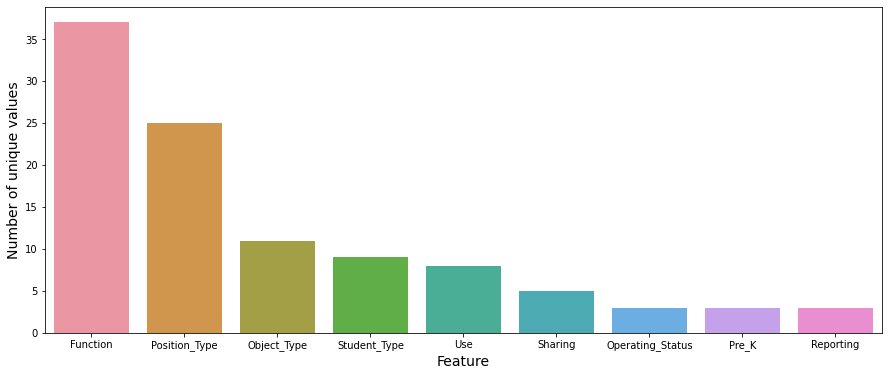

In [16]:
# display unique values for each feature
n_unique_features = train_df[categorical_cols].apply(pd.Series.nunique).sort_values(ascending=False)
sns.barplot(x=n_unique_features.index, y=n_unique_features.values)
plt.xlabel('Feature')
plt.ylabel('Number of unique values')

In [17]:
categorical_dummies = pd.get_dummies(train_df[categorical_cols])
categorical_dummies.sample(5)

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Student_Type_Special Education,Student_Type_Unspecified,Use_Business Services,Use_ISPD,Use_Instruction,Use_Leadership,Use_NO_LABEL,Use_O&M,Use_Pupil Services & Enrichment,Use_Untracked Budget Set-Aside
97602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
348247,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
212694,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
270117,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
140874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Numerical Features

In [18]:
# look for possible numeric columns
numeric_cols = []
print("Numeric columns...")
for c in sorted(train_df.select_dtypes(include=["number"]).columns):
    print(f"  {c}")
    numeric_cols.append(c)

Numeric columns...
  FTE
  Total


In [19]:
numeric_data = train_df[numeric_cols].fillna(-1000)

## Text Features

In [20]:
non_text_cols = numeric_cols + categorical_cols
text_cols = []
print("Text columns...")
for c in sorted(train_df.columns):
    if c not in non_text_cols:
        print(f"  {c}")
        text_cols.append(c)

Text columns...
  Facility_or_Department
  Function_Description
  Fund_Description
  Job_Title_Description
  Location_Description
  Object_Description
  Position_Extra
  Program_Description
  SubFund_Description
  Sub_Object_Description
  Text_1
  Text_2
  Text_3
  Text_4


In [21]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Join all text items in a row that have a space in between
text_vector = train_df[text_cols].fillna("").apply(lambda x: " ".join(x), axis=1)

# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 5039 tokens in the dataset
There are 3512 alpha-numeric tokens in the dataset


# Preprocessing

In [22]:
# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(
    numeric_data, categorical_dummies, size=0.2, seed=42)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")
print(X_test.info())
print("\ny_train info:")
print(y_train.info())
print("\ny_test info:")
print(y_test.info())

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     320222 non-null  float64
 1   Total   320222 non-null  float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 326408 to 413949
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     80055 non-null  float64
 1   Total   80055 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function_Aides Compensation to Use_Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 326408 to 413949
Columns: 104 entries, Functio

# Modeling

In [23]:
# model name
model_name = "models/ovr_logreg.joblib"

In [24]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

# save model
joblib.dump(clf, model_name) 

Accuracy: 0.0


['models/ovr_logreg.joblib']

In [25]:
# reload model
clf = joblib.load(model_name) 

# Generate predictions: predictions
predictions = clf.predict_proba(test_df[numeric_cols].fillna(-1000))

# Format predictions in DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(train_df[categorical_cols]).columns,
                             index=test_df.index,
                             data=predictions)


# Save prediction_df to csv
prediction_df.to_csv("datasets/predictions.csv")

<div class="alert alert-block alert-danger">
<b>WARNING</b></div>

Sorry, this exercise ends here because the peeps at Datacamp ensured that their tutorial is not fully reproducible by using a `score_submission` function that relies on a hidden file they do not share.

<div class="alert alert-block alert-danger">
<b>:(</b></div>